# Insurance Pricing with Machine Learning

This notebook serves as the baseline of performance for the most common statistical learning methods when dealing with insurance price prediction in the actuarial business.

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## The data

We will use the [French Motor Third-Party Liability Claims](https://www.openml.org/d/41214) dataset. This dataset has been studied in detail by A. Noll, R. Salzmann and M.V. Wuthrich, in their 2018 paper [Case Study: French Motor Third-Party Liability Claims](doi:10.2139/ssrn.3164764). 

Many assumptions and decisions made during the tests below were driven by this study.

In [2]:
from sklearn.datasets import fetch_openml


df = fetch_openml(data_id=41214, as_frame=True).frame
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
0,1.0,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,10.000000
1,3.0,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,1.298701
2,5.0,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,1.333333
3,10.0,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,11.111111
4,11.0,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,1.190476
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93,0.000000
678009,6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11,0.000000
678010,6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82,0.000000
678011,6114329.0,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26,0.000000


Study of the the dataset - distribution of our labels.

Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


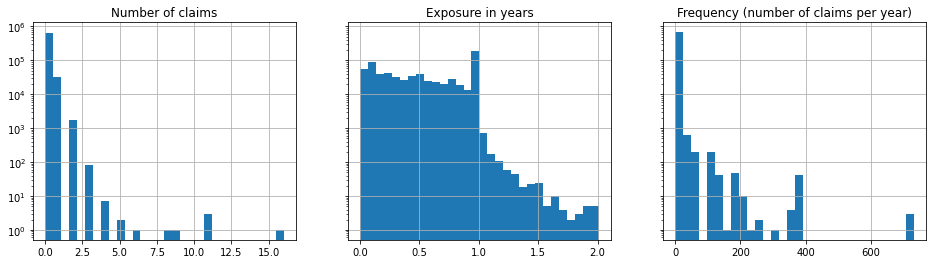

In [3]:
print("Average Frequency = {}"
      .format(np.average(df["Frequency"], weights=df["Exposure"])))

print("Fraction of exposure with zero claims = {0:.1%}"
      .format(df.loc[df["ClaimNb"] == 0, "Exposure"].sum() /
              df["Exposure"].sum()))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4), sharey=True)
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

### Cleaning up the data

We need to clean the data before feeding it to our models. In the following steps, we use SKLearn's encoders to properly encode the columns "Area", "VehBrand", "VehGas" and "Region" into something that the Tree can work with.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False),
    StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
    ],
    remainder="drop",
)

## The models

This example contains a dummy regressor model to serve as the base, a Ridge Regressor (simple linear model), a Poisson Regressor (linear model used for frequency predictions in the actuarial business, since they follow a Poisson distribution) and a Gradient Boosted Tree.

In [5]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", DummyRegressor(strategy='mean')),
]).fit(df_train, df_train["Frequency"],
       regressor__sample_weight=df_train["Exposure"])

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print("MSE: %.3f" %
          mean_squared_error(df_test["Frequency"], y_pred,
                             sample_weight=df_test["Exposure"]))
    print("MAE: %.3f" %
          mean_absolute_error(df_test["Frequency"], y_pred,
                              sample_weight=df_test["Exposure"]))

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(f"WARNING: Estimator yields invalid, non-positive predictions "
              f" for {n_masked} samples out of {n_samples}. These predictions "
              f"are ignored when computing the Poisson deviance.")

    print("mean Poisson deviance: %.3f" %
          mean_poisson_deviance(df_test["Frequency"][mask],
                                y_pred[mask],
                                sample_weight=df_test["Exposure"][mask]))


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


In [7]:
from sklearn.linear_model import Ridge


ridge_glm = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", Ridge(alpha=1e-6)),
]).fit(df_train, df_train["Frequency"],
       regressor__sample_weight=df_train["Exposure"])

In [8]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.177
mean Poisson deviance: 0.601


In [9]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300))
])
poisson_glm.fit(df_train, df_train["Frequency"],
                regressor__sample_weight=df_train["Exposure"])

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


In [10]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder


tree_preprocessor = ColumnTransformer(
    [
        ("categorical", OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
        ("numeric", "passthrough",
            ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline([
    ("preprocessor", tree_preprocessor),
    ("regressor", HistGradientBoostingRegressor(loss="poisson",
                                                max_leaf_nodes=128)),
])
clf = poisson_gbrt.fit(df_train, df_train["Frequency"],
                 regressor__sample_weight=df_train["Exposure"])

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

Poisson Gradient Boosted Trees evaluation:
MSE: 0.570
MAE: 0.184
mean Poisson deviance: 0.576


In [11]:
from mlinsights.plotting import pipeline2str, pipeline2dot
print(pipeline2str(poisson_gbrt))

Pipeline
   ColumnTransformer
      OrdinalEncoder(VehBrand,VehPower,VehGas,Region,Area)
      PassThrough(VehAge,DrivAge,BonusMalus,Density)
   HistGradientBoostingRegressor


In [12]:
dot = pipeline2dot(ridge_glm, list(df.columns.values))
dot_file = "graph2.dot"
with open(dot_file, "w", encoding="utf-8") as f:
    f.write(dot)

To evaluate the difference between those models, we can compare observed target values with the predicted values for each model.

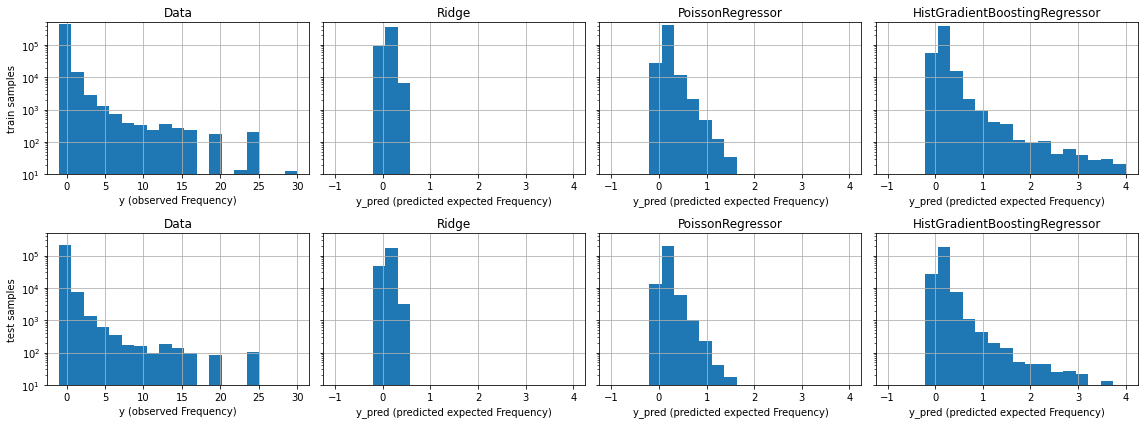

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2),
                              ["train", "test"],
                              [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins),
                         ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale('log')
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(bins=np.linspace(-1, 4, n_bins),
                               ax=axes[row_idx, idx+1])
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale='log',
            xlabel="y_pred (predicted expected Frequency)"
        )
plt.tight_layout()

Actual number of claims: 11935.0
Predicted number of claims by Ridge(alpha=1e-06): 10693.0
Predicted number of claims by PoissonRegressor(alpha=1e-12, max_iter=300): 11930.8
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 12206.3
Predicted number of claims by DummyRegressor(): 11931.2


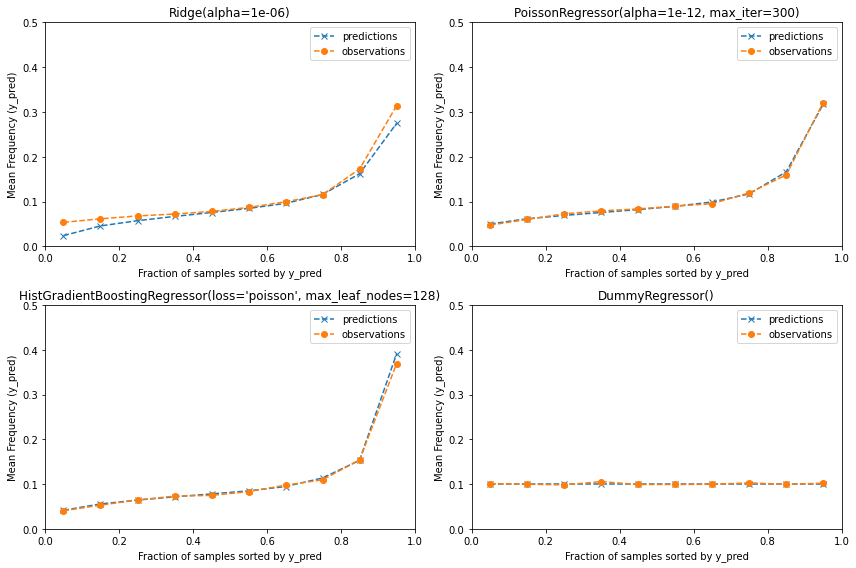

In [14]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None,
                                  n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1/n_bins) + 0.5/n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(
            y_pred[idx_sort][sl], weights=weights
        )
        y_true_bin[n] = np.average(
            y_true[idx_sort][sl],
            weights=weights
        )
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['ClaimNb'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt,
                                   dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["Frequency"].values
    exposure = df_test["Exposure"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10)

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: "
          f"{np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker='x', linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker='o', linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel='Fraction of samples sorted by y_pred',
        ylabel='Mean Frequency (y_pred)'
    )
    axi.legend()
plt.tight_layout()


Only the Ridge model seems to underperform and thus underestimate the number of claims of this dataset. The other models do well by correctly estimating the claims, or overestimating them sometimes (safer than underestimating them).

## Presentation to baringa

The following code was created solely for the purpose of giving the presentation on the basics of machine learning to baringa on the 9th of July 2021.

In [15]:
new_df = df[["VehAge", "DrivAge", "VehPower", "Frequency"]]
sample_df = new_df[(new_df["Frequency"]==1) | (new_df["Frequency"]==2) | (new_df["Frequency"]==3) | (new_df["Frequency"]==4) | (new_df["Frequency"]==5)].sample(n=10, weights='Frequency', random_state=18)

In [16]:
# Mock dataset for creating a simple tree
sample_df["Name"]=["Simona", "Greg", "Rick", "Betony", "Lucius", "Sheila", "Bart", "Maverick", "Paige", "Ruby"]
sample_df = sample_df.set_index("Name").sort_index()
sample_df

,VehAge,DrivAge,VehPower,Frequency
Name,,,,
Bart,6.0,30.0,6.0,1.0
Betony,7.0,36.0,5.0,1.0
Greg,10.0,44.0,7.0,1.0
Lucius,2.0,37.0,5.0,2.0
Maverick,8.0,78.0,11.0,3.0
Paige,16.0,54.0,6.0,1.0
Rick,6.0,50.0,10.0,2.0
Ruby,1.0,48.0,4.0,2.0
Sheila,14.0,38.0,8.0,5.0


In [17]:
from sklearn.tree import DecisionTreeRegressor
regr_tree = DecisionTreeRegressor(max_depth=2)
X, y = sample_df[["VehAge", "DrivAge", "VehPower"]], sample_df[["Frequency"]]
regr_tree.fit(X, y)

DecisionTreeRegressor(max_depth=2)

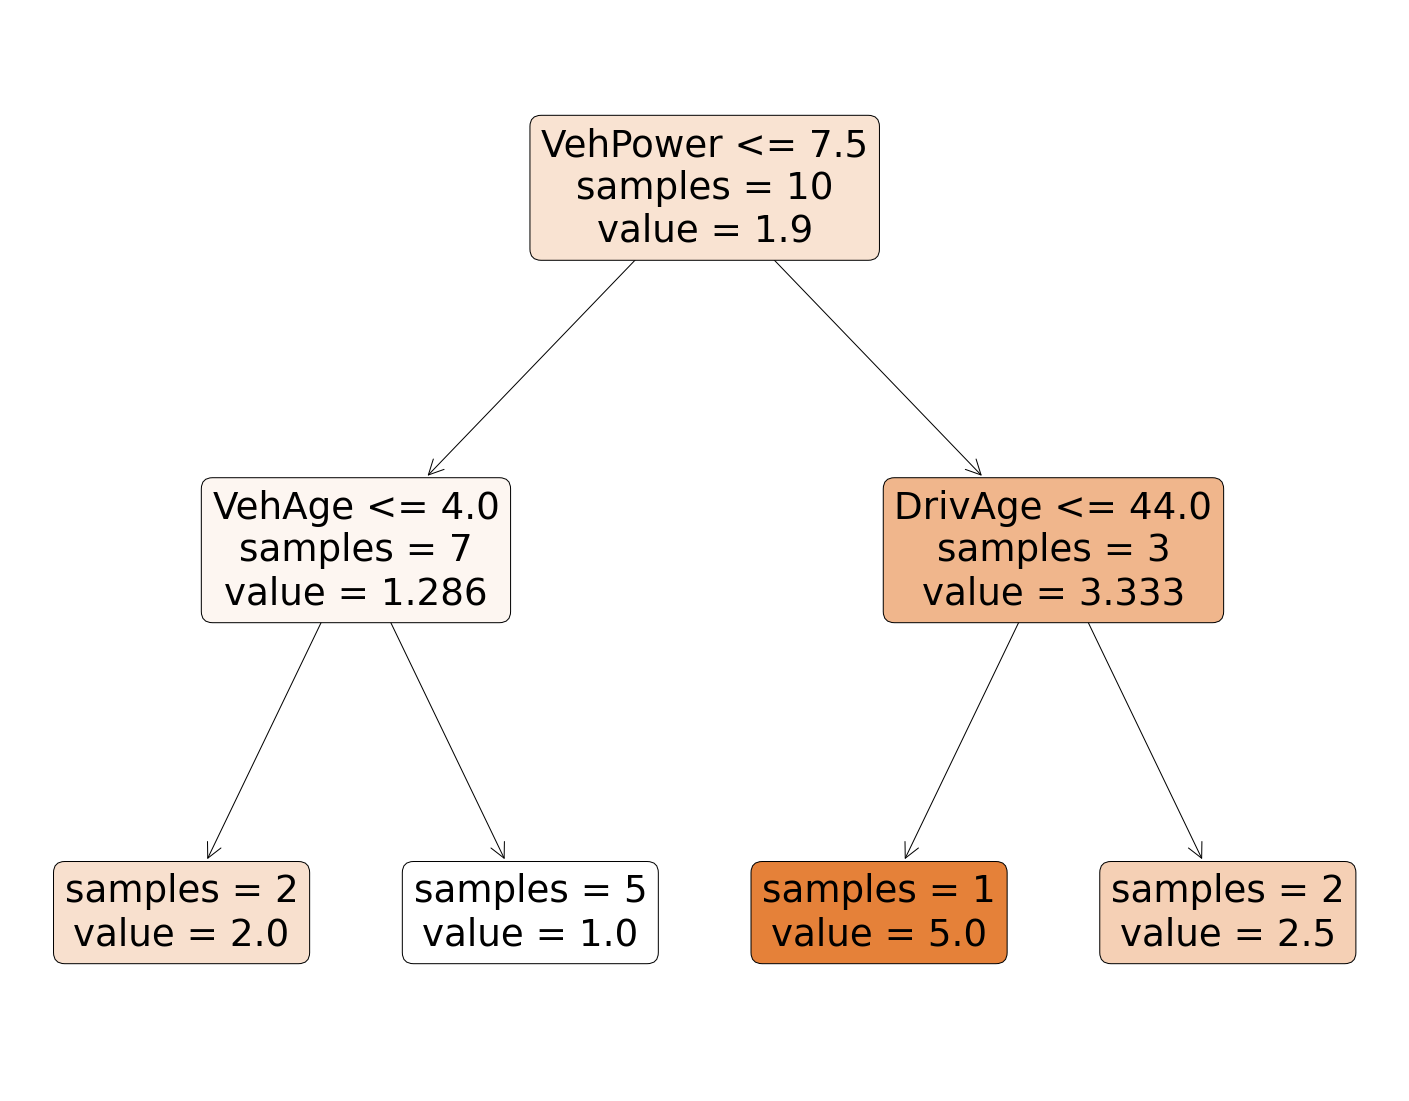

In [18]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr_tree,
                   impurity=False,
                   feature_names=X.columns,  
                   class_names="Frequency",
                   rounded=True,
                   filled=True)

In [19]:
print(y.columns)

Index(['Frequency'], dtype='object')


Explaining underfitting and overfitting.

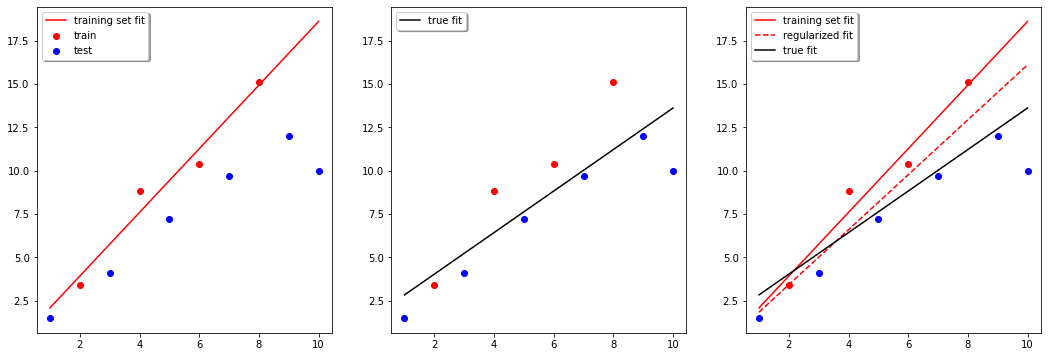

In [20]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([1.5, 3.4, 4.1, 8.8, 7.2, 10.4, 9.7, 15.1, 12.0, 10])
x_train, x_test = np.array([2, 4, 6, 8]), np.array([1, 3, 5, 7, 9, 10])
y_train, y_test = np.array([3.4, 8.8, 10.4, 15.1]), np.array([1.5, 4.1, 7.2, 9.7, 12.0, 10])

m_train, b_train = np.polyfit([2, 4, 6, 8], [3.4, 8.8, 10.4, 15.1], 1)
m, b = np.polyfit(x, y, 1)


fig, ax = plt.subplots(figsize=(18,6), sharey=True)
ax1= plt.subplot(1,3,1) 
ax2= plt.subplot(1,3,2) 
ax3= plt.subplot(1,3,3) 

ax1.scatter(x_train, y_train, c='r', label="train")
ax1.scatter(x_test, y_test, c='b', label="test")
ax1.plot(x, m_train*x + b_train, color='red', label="training set fit")
ax1.legend(loc='upper left', shadow=True)

ax2.scatter(x_train, y_train, c='r')
ax2.scatter(x_test, y_test, c='b')
ax2.plot(x, m_train*x + b_train, color='red', alpha=0)
ax2.plot(x, (m_train-0.25)*x + b_train, 'r--', alpha=0)
ax2.plot(x, m*x + b, color='black', label="true fit")
ax2.legend(loc='upper left', shadow=True)

ax3.scatter(x_train, y_train, c='r')
ax3.scatter(x_test, y_test, c='b')
ax3.plot(x, m_train*x + b_train, 'r', label="training set fit")
ax3.plot(x, (m_train-0.25)*x + b_train, 'r--', label="regularized fit")
ax3.plot(x, m*x + b, color='black', label="true fit")
ax3.legend(loc='upper left', shadow=True)
